In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import segyio
import random
import os
import json

## Чтение файла атрибутов

Как видно, максимальное и минимальное значения равны 1 и 0 соответственно.
Следовательно, нормализация не требуется.

First iline at 312
Max value: 1.0, min value: 0.0


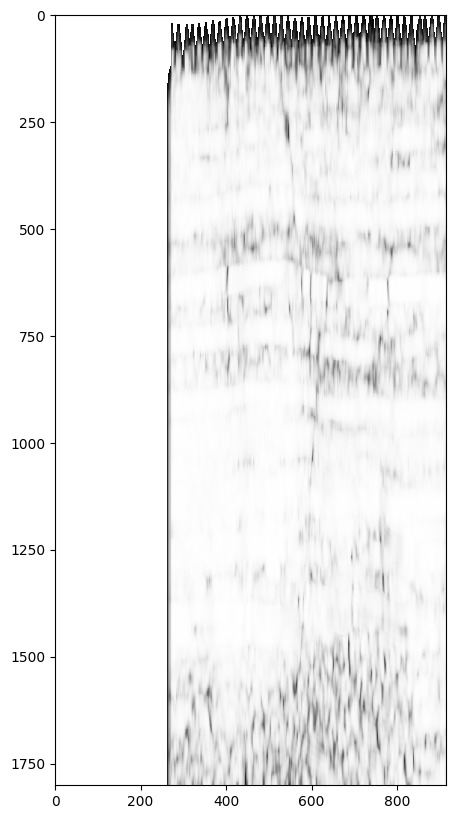

In [2]:
variance_data_path = '../additional cube/data/raw/FullStack_PSTM_Variance.sgy'
variance_max = np.NINF
variance_min = np.Inf
with segyio.open(variance_data_path) as segy_file:
    variance_iline_shift = segy_file.ilines[0]
    for segy_slice in segy_file.iline:
        if (local_max := np.max(segy_slice)) > variance_max:
            variance_max = local_max
        if (local_min := np.min(segy_slice)) < variance_min:
            variance_min = local_min
    print(f'First iline at {variance_iline_shift}')
    print(f'Max value: {variance_max}, min value: {variance_min}')
    segy_slice = segy_file.iline[612].T

plt.figure(figsize=(10,10))
plt.imshow(segy_slice, interpolation='nearest', cmap='Greys');

## Разбиение срезов на train и test

In [3]:
segy_data = np.load('../additional cube/data/raw/numpy/inline_data.npz')['arr_0']
min_segy_value = np.min(segy_data)
max_segy_value = np.max(segy_data)
segy_data = (segy_data - min_segy_value) / (max_segy_value - min_segy_value) * 255
labels = np.load('../additional cube/data/raw/numpy/inline_faults_thick_7.npz')['arr_0']

total_slices = list(range(np.shape(labels)[0]))
random.shuffle(total_slices)

split_index = int(len(total_slices) * 0.2)

train_slices_nums = total_slices[split_index:]
eval_slices_nums = total_slices[:split_index]
print(len(train_slices_nums))
print(len(eval_slices_nums))

519
129


## Сохранение обучающих кубов

In [4]:
WINDOW_SIZE = 512
WINDOW_THRESHOLD = 2000
WINDOWS_PER_SLICE = 4
ATTEMPTS = 20
SAVE_PATH = os.path.join('data', 'prepared')

for stage in (['train', 'eval']):
    if stage == 'train':
        slices_nums = train_slices_nums
    elif stage == 'eval':
        slices_nums = eval_slices_nums
    fault_save_path = os.path.join(SAVE_PATH, stage, 'fault')
    seis_save_path = os.path.join(SAVE_PATH, stage, 'seis')
    variance_save_path = os.path.join(SAVE_PATH, stage, 'variance')
    img_cnt = 0
    metadata = []
    for slice_num in slices_nums:
        with segyio.open(variance_data_path) as variance_file:
            variance_slice = variance_file.iline[slice_num + variance_iline_shift].T
        data_slice = segy_data[slice_num]
        labels_slice = labels[slice_num]
        timelines, xlines = np.shape(data_slice)
        for _ in range(WINDOWS_PER_SLICE):
            attempts = 0
            while True:
                random_xline = random.randint(0, xlines - WINDOW_SIZE)
                random_timeline = random.randint(0, timelines - WINDOW_SIZE)
                random_labels_window = labels_slice[random_timeline:random_timeline+WINDOW_SIZE, random_xline:random_xline+WINDOW_SIZE]
                if np.sum(random_labels_window) > WINDOW_THRESHOLD or attempts == ATTEMPTS:
                    break
                else:
                    attempts += 1
            if attempts == ATTEMPTS:
                continue
            random_data_window = data_slice[random_timeline:random_timeline+WINDOW_SIZE, random_xline:random_xline+WINDOW_SIZE]
            random_variance_window = variance_slice[random_timeline:random_timeline+WINDOW_SIZE, random_xline:random_xline+WINDOW_SIZE]
            metadata.append({
                    'data': f'{img_cnt}.png',
                    'label': f'{img_cnt}.png',
                    'variance': f'{img_cnt}.png'
                })
            data_img = ImageOps.grayscale(Image.fromarray(random_data_window))
            label_img = ImageOps.grayscale(Image.fromarray((random_labels_window * 255)))
            variance_img = ImageOps.grayscale(Image.fromarray(random_variance_window * 255))
            data_img.save(os.path.join(seis_save_path, f'{img_cnt}.png'))
            label_img.save(os.path.join(fault_save_path, f'{img_cnt}.png'))
            variance_img.save(os.path.join(variance_save_path, f'{img_cnt}.png'))
            img_cnt += 1
    with open(os.path.join(SAVE_PATH, stage, 'metadata.json'), 'w') as file:
        json.dump(metadata, file)